# Lasso coefficients comparison
---
***Objective:*** The objetive of this notebook is to apply the Lasso regression with several kinds of priors and compare it's coefficients.

***Author:*** Bruno G. de Oliveira

### 1) Importing packages

In [8]:
import sys 
sys.path.append('../')

# Data manipulation 
import pandas as pd 
import numpy as np 
pd.options.display.max_rows=None

# Dataset creation
from dataset.generate_regression_data import RegressionData

# Probabilistic programming
import pymc3 as pm 
import theano as T
from models.regularized_horseshoe import bayesian_lr_with_regularized_horseshoe

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 

### 2) Create toy dataset

This dataset is built usign scikit-learn function called `make_regression`(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression) which simulates data from a multivariate normal distribution and we can pass as parameters the number of samples, the number of features and the number of informative features that we want.

In [15]:
args = {
    'n_samples': 100,
    'n_features': 10,
    'nonzero_features': 4,
    'seed': 42
}

In [16]:
data = RegressionData(args)
X, y, coefs = data.generate()

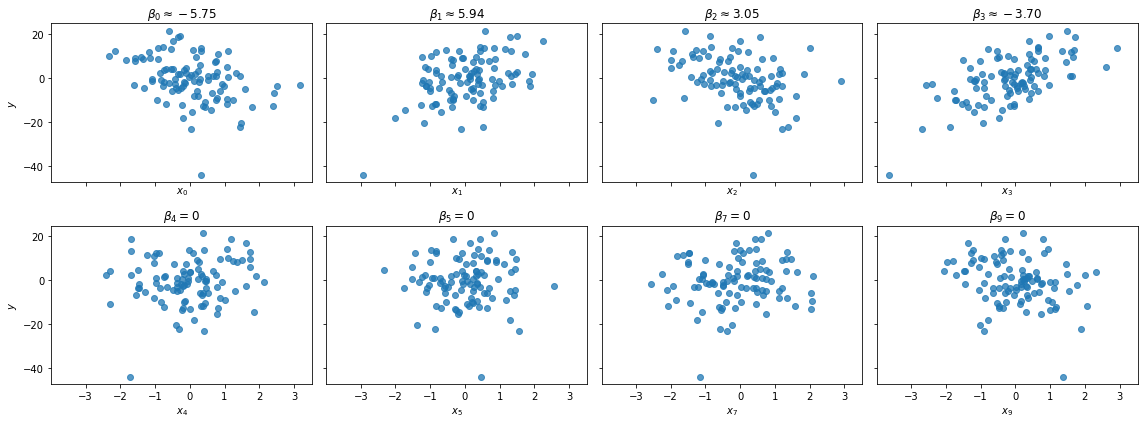

In [17]:
_ = data.plot(X, y, coefs)

### 3) Exploratory data analysis

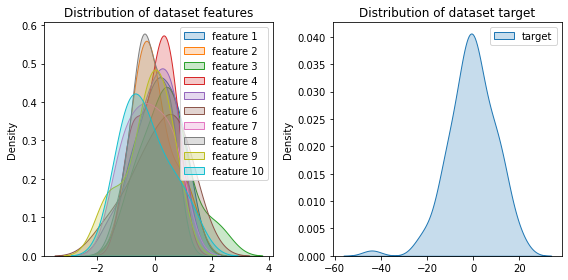

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), tight_layout=True)

for i in range(X[:, :10].shape[1]):
    sns.kdeplot(X[i], shade=True, label=f'feature {i + 1}', ax=ax[0])
ax[0].legend()
ax[0].set_title('Distribution of dataset features')

sns.kdeplot(y, shade=True, label='target', ax=ax[1])
ax[1].legend()
ax[1].set_title('Distribution of dataset target');

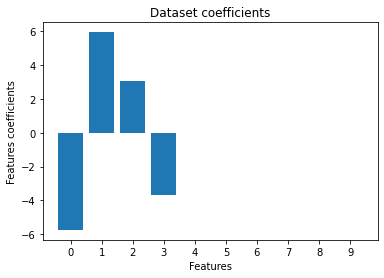

In [21]:
x = range(coefs.size)
plt.bar(x, coefs)
plt.xticks(x)
plt.xlabel('Features')
plt.ylabel('Features coefficients')
plt.title('Dataset coefficients');

### 4) Constructing the models

In [22]:
X_t = T.shared(X)

#### 4.3) Horseshoe

In [23]:
reg_horseshoe = bayesian_lr_with_regularized_horseshoe(X, y, args['nonzero_features'])

In [24]:
CHAINS = 3

SAMPLE_KWARGS = {
    'cores': CHAINS,
    'target_accept': 0.99,
    'max_treedepth': 15,
    'random_seed': [args['seed'] + i for i in range(CHAINS)],
    'return_inferencedata': True
}

with reg_horseshoe:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta_0, z, c2, lambda, tau, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 296 seconds.
The number of effective samples is smaller than 25% for some parameters.


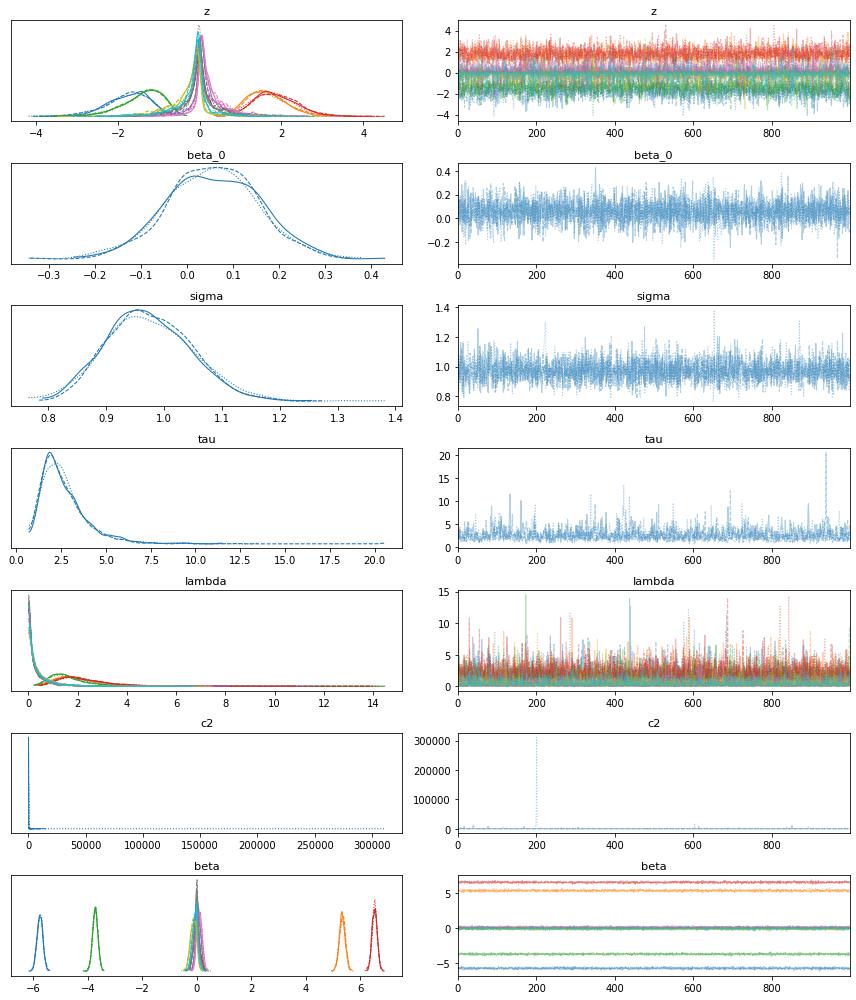

In [25]:
pm.plot_trace(trace)
plt.tight_layout();

In [26]:
trace_summary = pm.summary(trace, round_to=2)
trace_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%']]

,mean,sd,hdi_3%,hdi_97%
z[0],-1.75,0.54,-2.78,-0.80
z[1],1.66,0.51,0.72,2.61
z[2],-1.39,0.51,-2.38,-0.56
z[3],1.86,0.54,0.90,2.85
z[4],0.13,0.50,-0.83,1.31
z[5],-0.03,0.49,-1.19,0.86
z[6],0.25,0.48,-0.48,1.38
z[7],-0.03,0.47,-1.08,0.94
z[8],-0.30,0.47,-1.41,0.38
z[9],-0.17,0.48,-1.24,0.75


In [30]:
beta_idx = [idx for idx in trace_summary.index if idx.startswith('beta')]
beta_coefs = trace_summary.loc[beta_idx, 'mean']

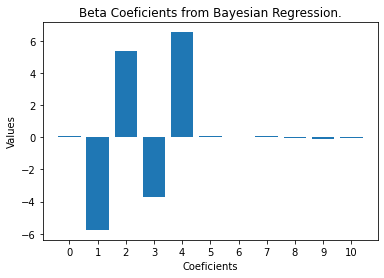

In [31]:
x = range(beta_coefs.size)
plt.bar(x, beta_coefs)
plt.xticks(x)
plt.title('Beta Coeficients from Bayesian Regression.')
plt.xlabel('Coeficients')
plt.ylabel('Values');